In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [2]:
textprops = dict(fontsize='large', fontfamily='sans serif')
    
def top_countries_proportion(data, category, cmap, n=8, ax=None):
    other = data[n:].sum()
    today_top = data[:n].append(pd.Series(data=other, index=['Others']))
    if not ax:
        fig, ax = plt.subplots(figsize=(16, 6.6))
    explode = np.zeros(n+1)
    explode[:] = 0.02
    norm = mpl.colors.Normalize(vmin=today_top.min()/1.25, vmax=today_top.max()*1.25)
    colors = mpl.cm.get_cmap(cmap)(norm(today_top))
    patches, texts, autotexts = ax.pie(today_top, labels=today_top.index, pctdistance=0.7,
                                       explode=explode, autopct='%.1f%%', textprops=textprops,
                                       colors=colors)
    for t, p in zip(autotexts, patches):
        t.set_fontsize(10)
        if np.array(p.get_facecolor()).prod() < 0.1:
            t.set_color('w')
#     ax.set_title('Global {} proportions'.format(category))

In [3]:
font_dict = dict(fontsize='large', fontfamily='sans serif')

def label(rects, ax):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ax.annotate('{}'.format(int(width)),
                    xy=(width, rect.get_y() + height / 2), xytext=(25, 0),
                    textcoords="offset points",ha='center', va='center')

def top_countries(data, category, cmap, n=20):
    data_top = data[:n]

    fig, ax = plt.subplots(figsize=(15, 10))
    color = mpl.cm.get_cmap(cmap)(mpl.colors.LogNorm(vmin=data_top.min()/1.5, vmax=data_top.max()*1.5)(data_top))
    rects = ax.barh(range(data_top.shape[0]), data_top, color=color)
    label(rects, ax)

    ax.set_xlabel('cases ($\\times10^3$)', font_dict)
    ax.set_xticklabels(ax.get_xticks() / 1e3, font_dict)
    ax.set_yticks(range(n))
    ax.set_yticklabels(data_top.index, font_dict)
    ax.invert_yaxis()
    ax.set_title(f'Top {n} countries with the most {category}', font_dict)
    ax.grid(True, axis='x')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax = fig.add_axes([0.45, 0.15, 0.5, 0.5])
    top_countries_proportion(data, category, cmap, ax=ax)
    plt.savefig(f'global/{category}.png', bbox_inches='tight')

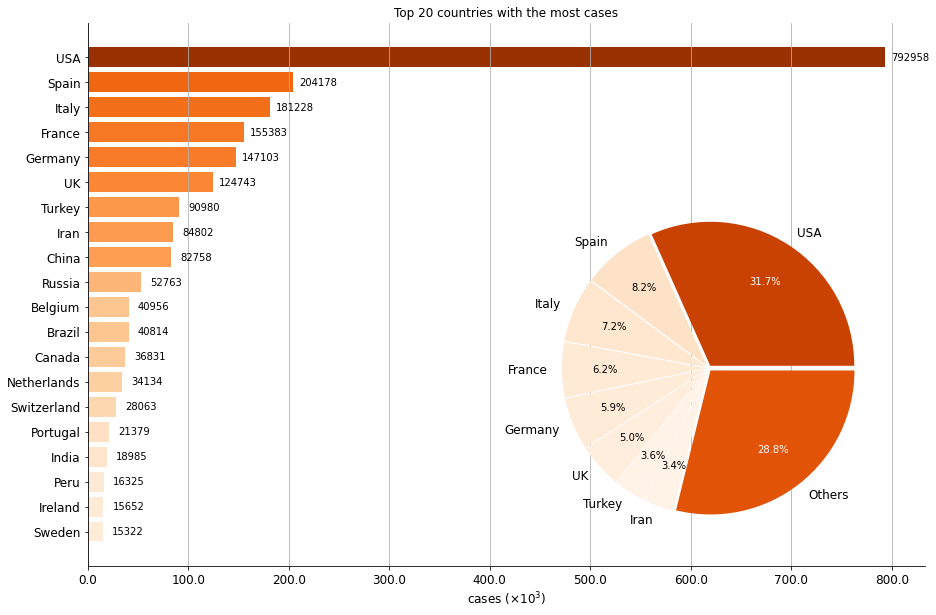

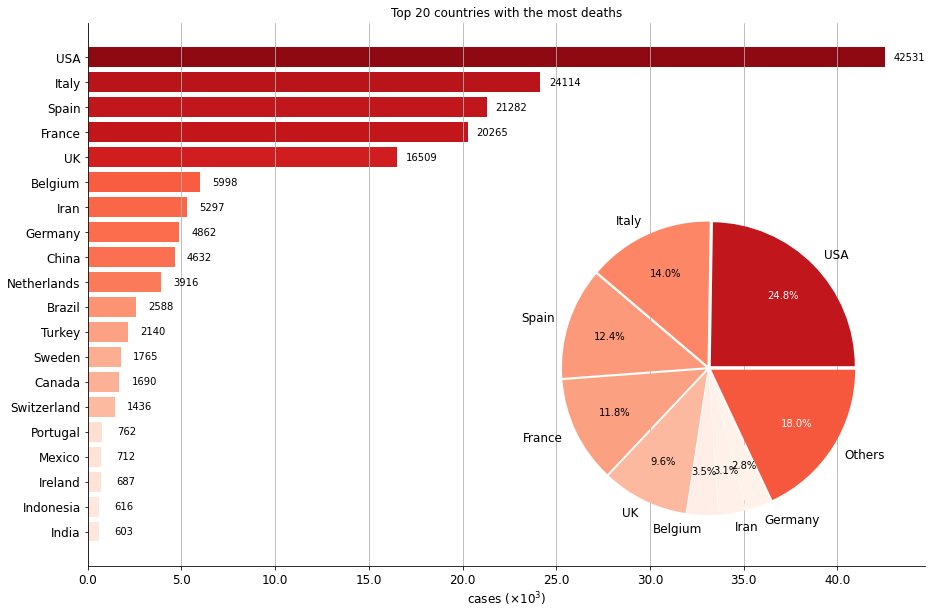

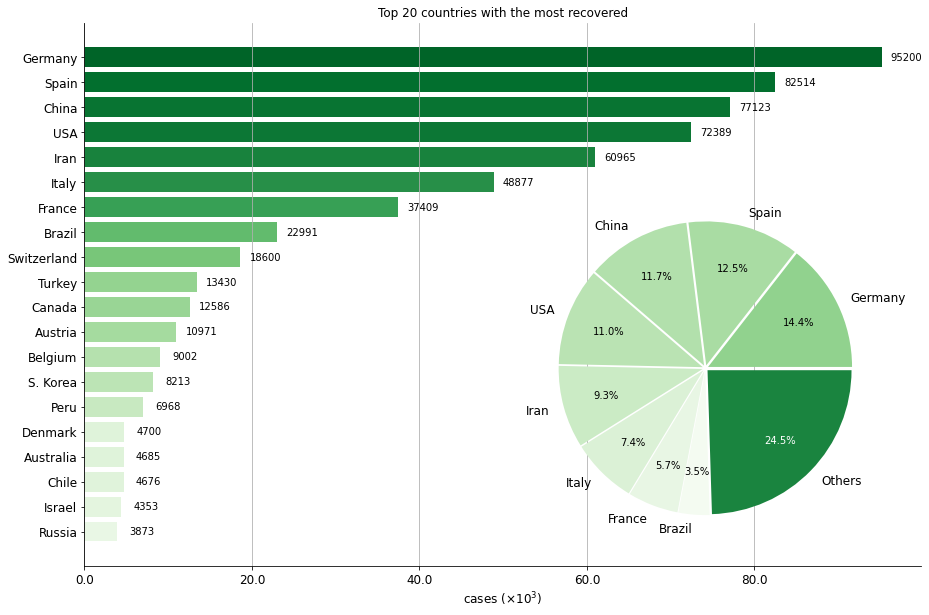

In [4]:
# today = datasets.pomber().groupby('Country').last()
today = datasets.virus_tracker_web()

# sort data by different criteria
today_cases = today.sort_values('Cases', ascending=False)
today_deaths = today.sort_values('Deaths', ascending=False)
today_recovered = today.sort_values('Recovered', ascending=False)

# arugments for ploting
cases = [today_cases['Cases'], 'cases', 'Oranges']
deaths = [today_deaths['Deaths'], 'deaths', 'Reds']
recoverd = [today_recovered['Recovered'], 'recovered', 'Greens']

top_countries(*cases)
top_countries(*deaths)
top_countries(*recoverd)

In [5]:
today.head()

,Cases,New Cases,Deaths,New Deaths,Recovered,Active,Serious
Country,,,,,,,
USA,792958,199,42531,17,72389,678038,13951
Spain,204178,3968,21282,430,82514,100382,7705
Italy,181228,0,24114,0,48877,108237,2573
France,155383,0,20265,0,37409,97709,5683
Germany,147103,38,4862,0,95200,47041,2889


In [6]:
def today_new(ax, category, threshold, color):
    new = today[category].sort_values(ascending=False)
    data = new[new > threshold]
    ax.bar(x=data.index, height=data.values, fc=color)
    ax.set_xticklabels(data.index, rotation=60)
    ax.set_title(f"Countries with over {threshold} new {category.split(' ')[1].lower()} today")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

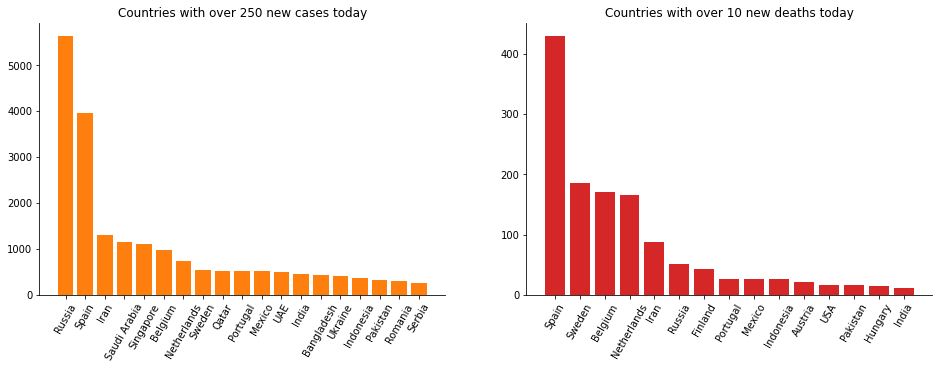

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
today_new(ax0, 'New Cases', 250, 'tab:orange')
today_new(ax1, 'New Deaths', 10, 'tab:red')
plt.savefig('global/today_new.png', bbox_inches='tight')

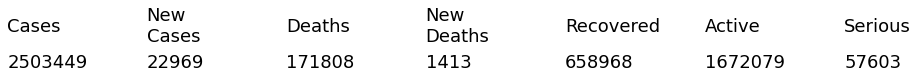

In [8]:
fig, ax = plt.subplots(figsize=(16, 1))
ax.set_xlim(0, 8)
ax.set_ylim(0, 0.75)
ax.axis('off')
font_dict = dict(fontsize=18, ha='left', va='center', wrap=True)
for i, (l, c) in enumerate(today.sum().iteritems()):
    ax.text(i*1.25, 0.5, l.replace(' ', '\n'), font_dict) # text
    ax.text(i*1.25, 0, c, font_dict) # number
plt.savefig('global/summary.png', bbox_pad='tight')

In [9]:
# markdown table
global_stat = today.sum().to_frame().T
global_stat.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
print(global_stat.to_markdown(showindex=False, floatfmt=".0f"))

|   Cases |   New Cases |   Deaths |   New Deaths |   Recovered |   Active |   Serious |
|--------:|------------:|---------:|-------------:|------------:|---------:|----------:|
| 2503449 |       22969 |   171808 |         1413 |      658968 |  1672079 |     57603 |
